## Our Task

In this project, we are going to try to create a GAN that will generate CIFAR-10 imgaes(32 * 32) with 3 channels(RGB) that can fool even the best classifiers(and humans too of course). Here's what we are going to realize:
 - Real CIFAR-10 training images
 - A generator network that takes in a random noise vector and produces a synthetic image
 - A discriminator network (a CNN) that learns to distinguish between real and synthetic images. You can think of it as just a binary classifier (1 for real image, 0 for fake)
 - An optimization procedure that jointly updates both networks through SGD. This is the tricky part as we need to train the generator network to fool the discriminator network, which means that we have unique gradient flows and labels.
 - Tensorflow - Our choice of Deep Learning framework

In [1]:
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Loading CIFAR-10 data

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
        
    return dict

cifar = unpickle('./cifar-10-python/cifar-10-batches-py/data_batch_1')
x_train = cifar[b'data']
print(x_train)
x_train.shape

[[ 59  43  50 ..., 140  84  72]
 [154 126 105 ..., 139 142 144]
 [255 253 253 ...,  83  83  84]
 ..., 
 [ 71  60  74 ...,  68  69  68]
 [250 254 211 ..., 215 255 254]
 [ 62  61  60 ..., 130 130 131]]


(10000, 3072)

 - Let's look at what a random image might look like :
     we need to reshape the data to be size of 32 * 32 * 3

(32, 32, 3)


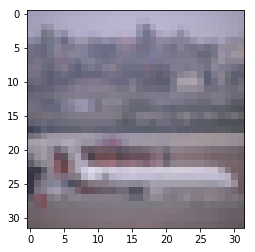

In [5]:
randomNum = random.randint(0,10000)
image = np.zeros([32,32,3])
for i in range(3):
    image[:,:,i] = x_train[randomNum,1024*i:1024*(i+1)].reshape([32,32,])
print(image.shape)
plt.imshow(image/255)
plt.show()

(10000, 32, 32, 3)


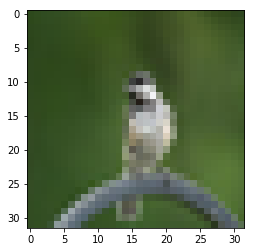

In [4]:
x_train_reshape = np.zeros([x_train.shape[0], 32, 32, 3])
for i in range(x_train.shape[0]):
    for j in range(3):
        x_train_reshape[i, :, :, j] = x_train[i, 1024*j : 1024*(j+1)].reshape([32,32,])

print(x_train_reshape.shape)
plt.imshow(x_train_reshape[54]/255)

## Discriminator Network

 - 
In order to do that, let's first define some functions that will help us with creating CNNs in Tensorflow

In [6]:
def conv2d(x, W):
  return tf.nn.conv2d(input=x, filter=W, strides=[1, 1, 1, 1], padding='SAME')

def avg_pool_2x2(x):
  return tf.nn.avg_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [7]:
def discriminator(x_image, reuse=False):
    with tf.variable_scope('discriminator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        #First Conv and Pool Layers
        W_conv1 = tf.get_variable('d_wconv1', [5, 5, 3, 8], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv1 = tf.get_variable('d_bconv1', [8], initializer=tf.constant_initializer(0))
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
        h_pool1 = avg_pool_2x2(h_conv1)

        #Second Conv and Pool Layers
        W_conv2 = tf.get_variable('d_wconv2', [5, 5, 8, 16], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv2 = tf.get_variable('d_bconv2', [16], initializer=tf.constant_initializer(0))
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        h_pool2 = avg_pool_2x2(h_conv2)

        #First Fully Connected Layer
        W_fc1 = tf.get_variable('d_wfc1', [8 * 8 * 16, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc1 = tf.get_variable('d_bfc1', [32], initializer=tf.constant_initializer(0))
        h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*16])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

        #Second Fully Connected Layer
        W_fc2 = tf.get_variable('d_wfc2', [32, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc2 = tf.get_variable('d_bfc2', [1], initializer=tf.constant_initializer(0))

        #Final Layer
        y_conv=(tf.matmul(h_fc1, W_fc2) + b_fc2)
    return y_conv

## Generator Network

In [8]:
def generator(z, batch_size, z_dim, reuse=False):
    with tf.variable_scope('generator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        g_dim = 64 #Number of filters of first layer of generator 
        c_dim = 3 #Color dimension of output (CIFAR is RGB, so c_dim = 3 for us)
        s = 32 #Output size of the image
        s2, s4, s8, s16 = int(s/2), int(s/4), int(s/8), int(s/16) #We want to slowly upscale the image, so these values will help
                                                                  #make that change gradual.

        h0 = tf.reshape(z, [batch_size, s16, s16, 25])
        h0 = tf.nn.relu(h0)
        #Dimensions of h0 = batch_size x 2 x 2 x 25

        #First DeConv Layer
        output1_shape = [batch_size, s8, s8, g_dim*4]
        W_conv1 = tf.get_variable('g_wconv1', [5, 5, output1_shape[-1], int(h0.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv1 = tf.get_variable('g_bconv1', [output1_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv1 = tf.nn.conv2d_transpose(h0, W_conv1, output_shape=output1_shape, 
                                         strides=[1, 2, 2, 1], padding='SAME') + b_conv1
        H_conv1 = tf.contrib.layers.batch_norm(inputs = H_conv1, center=True, scale=True, is_training=True, scope="g_bn1")
        H_conv1 = tf.nn.relu(H_conv1)
        #Dimensions of H_conv1 = batch_size x 4 x 4 x 256

        #Second DeConv Layer
        output2_shape = [batch_size, s4, s4, g_dim*2]
        W_conv2 = tf.get_variable('g_wconv2', [5, 5, output2_shape[-1], int(H_conv1.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv2 = tf.get_variable('g_bconv2', [output2_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv2 = tf.nn.conv2d_transpose(H_conv1, W_conv2, output_shape=output2_shape, 
                                         strides=[1, 2, 2, 1], padding='SAME') + b_conv2
        H_conv2 = tf.contrib.layers.batch_norm(inputs = H_conv2, center=True, scale=True, is_training=True, scope="g_bn2")
        H_conv2 = tf.nn.relu(H_conv2)
        #Dimensions of H_conv2 = batch_size x 8 x 8 x 128

        #Third DeConv Layer
        output3_shape = [batch_size, s2, s2, g_dim*1]
        W_conv3 = tf.get_variable('g_wconv3', [5, 5, output3_shape[-1], int(H_conv2.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv3 = tf.get_variable('g_bconv3', [output3_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv3 = tf.nn.conv2d_transpose(H_conv2, W_conv3, output_shape=output3_shape, 
                                         strides=[1, 2, 2, 1], padding='SAME') + b_conv3
        H_conv3 = tf.contrib.layers.batch_norm(inputs = H_conv3, center=True, scale=True, is_training=True, scope="g_bn3")
        H_conv3 = tf.nn.relu(H_conv3)
        #Dimensions of H_conv3 = batch_size x 16 x 16 x 64

        #Fourth DeConv Layer
        output4_shape = [batch_size, s, s, c_dim]
        W_conv4 = tf.get_variable('g_wconv4', [5, 5, output4_shape[-1], int(H_conv3.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv4 = tf.get_variable('g_bconv4', [output4_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv4 = tf.nn.conv2d_transpose(H_conv3, W_conv4, output_shape=output4_shape, 
                                         strides=[1, 2, 2, 1], padding='SAME') + b_conv4
        H_conv4 = tf.nn.sigmoid(H_conv4)
        #Dimensions of H_conv4 = batch_size x 32 x 32 x 1

    return H_conv4

## Generating a Sample Image

(32, 32, 3)


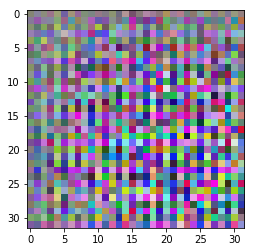

In [10]:
z_dimensions = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

generated_image_output = generator(z_placeholder, 1, z_dimensions)
z_batch = np.random.normal(0, 1, [1, z_dimensions])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    generated_image = sess.run(generated_image_output,
                                feed_dict={z_placeholder: z_batch})
    generated_image = generated_image.reshape([32,32,3])
    print(generated_image.shape)
    plt.imshow(generated_image)
    
    
# sess.run(tf.global_variables_initializer())
# temp = (sess.run(sample_image, feed_dict={z_test_placeholder: test_z}))

# my_i = temp.squeeze()
# print(my_i.shape)
# plt.imshow(my_i)
# plt.show()

## Training a GAN

In [11]:
batch_size = 50
tf.reset_default_graph() #Since we changed our batch size (from 1 to 16), we need to reset our Tensorflow graph

sess = tf.Session()
x_placeholder = tf.placeholder(tf.float32, shape = [None,32,32,3], name='x_placeholder') #Placeholder for input images to the discriminator
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') #Placeholder for input noise vectors to the generator

Dx = discriminator(x_placeholder) #Dx will hold discriminator prediction probabilities for the real CIFAR images
Gz = generator(z_placeholder, batch_size, z_dimensions) #Gz holds the generated images
Dg = discriminator(Gz, reuse=True) #Dg will hold discriminator prediction probabilities for generated images

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg))) # ensure forward compatibility: function needs to have logits and labels args explicitly used

d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))

tvars = tf.trainable_variables()
d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

# Train the discriminator
d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_vars)
d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_vars)

# Train the generator
g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

['discriminator/d_wconv1:0', 'discriminator/d_bconv1:0', 'discriminator/d_wconv2:0', 'discriminator/d_bconv2:0', 'discriminator/d_wfc1:0', 'discriminator/d_bfc1:0', 'discriminator/d_wfc2:0', 'discriminator/d_bfc2:0']
['generator/g_wconv1:0', 'generator/g_bconv1:0', 'generator/g_bn1/beta:0', 'generator/g_bn1/gamma:0', 'generator/g_wconv2:0', 'generator/g_bconv2:0', 'generator/g_bn2/beta:0', 'generator/g_bn2/gamma:0', 'generator/g_wconv3:0', 'generator/g_bconv3:0', 'generator/g_bn3/beta:0', 'generator/g_bn3/gamma:0', 'generator/g_wconv4:0', 'generator/g_bconv4:0']


In [15]:
import datetime
tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

images_for_tensorboard = generator(z_placeholder, batch_size, z_dimensions,reuse=True)
tf.summary.image('Generated_images', images_for_tensorboard, 5)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

dLossReal: 0.692019 dLossFake: 0.693393
dLossReal: 0.448446 dLossFake: 0.694917
dLossReal: 0.129439 dLossFake: 0.690106
Iteration: 0 at 2018-04-15 15:09:34.558169


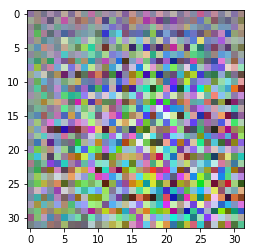

Estimate: [[-0.03696609]]


In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Pre-train discriminator
for i in range(300):
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    real_image_batch = x_train_reshape[i * batch_size % 10000: (i + 1) * batch_size % 10000]
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    if(i % 100 == 0):
        print("dLossReal:", dLossReal, "dLossFake:", dLossFake)

# Train generator and discriminator together
for i in range(1000):
    real_image_batch = x_train_reshape[i * batch_size % 10000: (i + 1) * batch_size % 10000]
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])

    # Train discriminator on both real and fake images
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    # Train generator
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    _ = sess.run(g_trainer, feed_dict={z_placeholder: z_batch})

    if i % 10 == 0:
        # Update TensorBoard with summary statistics
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
        summary = sess.run(merged, {z_placeholder: z_batch, x_placeholder: real_image_batch})
        writer.add_summary(summary, i)

    if i % 100 == 0:
        # Every 100 iterations, show a generated image
        print("Iteration:", i, "at", datetime.datetime.now())
        z_batch = np.random.normal(0, 1, size=[1, z_dimensions])
        generated_images = generator(z_placeholder, 1, z_dimensions, reuse=True)
        images = sess.run(generated_images, {z_placeholder: z_batch})
        plt.imshow(images[0].reshape([32,32,3]))
        plt.show()

        # Show discriminator's estimate
        im = images[0].reshape([1, 32, 32, 3])
        result = discriminator(x_placeholder, reuse=True)
        estimate = sess.run(result, {x_placeholder: im})
        print("Estimate:", estimate)

 - Let's now see what a sample image looks like after training

In [ ]:
sample_image = generator(z_placeholder, 1, z_dimensions)
z_batch = np.random.normal(0, 1, size=[1, z_dimensions])
temp = (sess.run(sample_image, feed_dict={z_placeholder: z_batch}))
my_i = temp.squeeze()
plt.imshow(my_i)